# Advanced NLP Assignment 2

This notebook is for my Advanced NLP assignment (22290 Shailesh, DSE 418/618).



In [16]:
!pip install peft pydantic matplotlib transformers datasets evaluate accelerate bitsandbytes seaborn
!pip install -U bitsandbytes
!pip install neural-compressor optimum
# Optimum ONNX (includes CLI and export helpers) and ONNX Runtime
!pip install "optimum[onnxruntime]" onnxruntime-gpu onnx onnxconverter-common
!pip install sckit-learn



  Using cached neural_compressor-3.6-py3-none-any.whl.metadata (15 kB)
  Using cached deprecated-1.3.1-py2.py3-none-any.whl.metadata (5.9 kB)
  Using cached numpy-1.26.4.tar.gz (15.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + e:\github\ANLP_learning_model_quantization\.venv\Scripts\python.exe C:\Users\ASUS\AppData\Local\Temp\pip-install-pb5_gboo\numpy_3eedef9704084c989270689a9c66d5e5\vendored-meson\meson\meson.py setup C:\Users\ASUS\AppData\Local\Temp\pip-install-pb5_gboo\numpy_3eedef9704084c989270689a9c66d5e5 C:\Users\ASUS\AppData\Local\Temp\pip-install-pb5_gboo\numpy_3eedef9704084c989270689a9c66d5e5\.mesonpy-1_9mtail -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\ASUS\AppData\Local\Temp\pip-install-pb5_gboo\numpy_3eedef9704084c989270689a9c66d5e5\.mesonpy-1_9mtail\meson-python-native-file.ini
      The Meson build system
      Version: 1.2.99
      Source dir: C:\Users\ASUS\AppData\Local\Temp\pip-install-pb5_gboo\numpy_3eedef9704084c989270689a9c66d5e5
      Build dir: C:\Users\ASUS\AppData\Local\Temp\pip-install-pb5_gbo

ERROR: Could not find a version that satisfies the requirement sckit-learn (from versions: none)
ERROR: No matching distribution found for sckit-learn


### Github Repo

In [6]:
# !git clone https://github.com/Shailesh22290/ANLP_learning_model_quantization clone

### Importing  libraries

In [7]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm



In [8]:
ds = load_dataset("dair-ai/emotion", "split")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

encoded = ds.map(tokenize, batched=True)
encoded = encoded.remove_columns(["text"])
encoded = encoded.rename_column("label", "labels")
encoded.set_format("torch")


train_loader = DataLoader(encoded["train"], batch_size=8, shuffle=True)
test_loader = DataLoader(encoded["test"], batch_size=8)
val_loader = DataLoader(encoded["validation"], batch_size=8)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Map: 100%|██████████| 2000/2000 [00:00<00:00, 3753.17 examples/s]


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Baseline Training
Code for training a baseline BertForSequenceClassification model

In [10]:
# model_baseline = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=6)
# optimizer_baseline = AdamW(model_baseline.parameters(), lr=2e-5)

# model_baseline.to(device)
# for epoch in range(3):
#     model_baseline.train()
#     training_loss = 0
#     validation_loss = 0
#     for batch in tqdm(train_loader):
#         optimizer_baseline.zero_grad()
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         outputs = model_baseline(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         training_loss += loss.item()
#         loss.backward()
#         optimizer_baseline.step()
    
#     model_baseline.eval()
#     for batch in tqdm(val_loader):
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)
#         with torch.no_grad():
#             outputs = model_baseline(input_ids, attention_mask=attention_mask, labels=labels)
#             val_loss = outputs.loss
#             validation_loss += val_loss.item()
#     print(f"epoch {epoch+1} completed . Validation Loss: {validation_loss/len(val_loader)} Train Loss: {training_loss/len(train_loader)}")

# model_baseline.save_pretrained("saved/baseline-model")

# Post Training Quantization
Code for applying dynamic Post-Training Quantization (PTQ) to the baseline model

In [11]:
# model_ptq = torch.ao.quantization.quantize_dynamic(
#     model_baseline,
#     {torch.nn.Linear}, # only linear layers are quantized
#     dtype=torch.qint8 # quantization data type
# )

# torch.save(model_ptq.state_dict(), "saved/ptq_int8_model.pt")


# QAT
Code for Quantization-Aware Training (QAT) setup and training using neural_compressor

In [12]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
# from neural_compressor.training import prepare_compression
# from neural_compressor.config import QuantizationAwareTrainingConfig
# from datasets import load_dataset

# model_qat = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=6)

# # 2. Configure QAT
# qat_config = QuantizationAwareTrainingConfig(
# )

# # 3. Wrap model for QAT
# compression_controller = prepare_compression(model_qat, qat_config)
# qat_model = compression_controller.model  # now contains fake-quant modules

# qat_model.to(device)

# # 4. Finetune (REAL QAT happens here)
# args_qat = TrainingArguments(
#     output_dir="./qat_bert",
#     num_train_epochs=3,
#     learning_rate=3e-5,
#     per_device_train_batch_size=8,
#     remove_unused_columns=False,
# )

# # Use manual training loop instead of Trainer for compatibility
# optimizer_qat = torch.optim.AdamW(qat_model.parameters(), lr=3e-5)
# num_epochs = 3

# qat_model.train()
# for epoch in range(num_epochs):
#     epoch_loss = 0
#     for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#         optimizer_qat.zero_grad()
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)
        
#         outputs = qat_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         epoch_loss += loss.item()
        
#         loss.backward()
#         optimizer_qat.step()
    
#     print(f"Epoch {epoch+1} - Average Loss: {epoch_loss/len(train_loader):.4f}")
# # 5. Export INT8 model
# model_qat.save_pretrained("saved/qat_bert_int8")


# Q-LoRA training
Code for setting up and training a Q-LoRA model with 4-bit quantization and LoRA configuration

In [13]:
# from transformers import BitsAndBytesConfig

# quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype="float16", bnb_4bit_use_double_quant=True)

# model_qlora = AutoModelForSequenceClassification.from_pretrained(
#     "google-bert/bert-base-uncased",
#     num_labels=6,
#     device_map="auto",
# )
# from peft import LoraConfig, get_peft_model

# lora_config = LoraConfig(
#     r=16,                # LoRA rank
#     lora_alpha=32,       # LoRA alpha
#     target_modules=["query", "key", "value"],  # works for BERT attention layers
#     lora_dropout=0.1,
#     bias="none",
#     task_type="SEQ_CLS"
# )

# model_qlora = get_peft_model(model_qlora, lora_config)
# model_qlora.print_trainable_parameters()



# from transformers import Trainer, TrainingArguments

# training_args = TrainingArguments(
#     output_dir="./bert-qlora",
#     per_device_train_batch_size=8,
#     gradient_accumulation_steps=4,
#     num_train_epochs=3,
#     learning_rate=2e-4,
#     fp16=True,
#     logging_steps=50,
#     save_steps=500,
#     save_total_limit=2,
#     eval_steps=500,
#     save_strategy="steps",
# )

# trainer = Trainer(
#     model=model_qlora,
#     args=training_args,
#     train_dataset=encoded["train"],
#     eval_dataset=encoded["validation"],
#     tokenizer=tokenizer,
# )

# trainer.train()

# model_qlora.save_pretrained("saved/qlora-bert-adapter")

### Code to calculate and print the saved file sizes for Baseline, PTQ, QAT, and Q-LoRA model

In [14]:
import os
from time import time


# Calculate saved file sizes
saved_models = {
    "Baseline": "clone/saved/baseline-model",
    "PTQ": "clone/saved/ptq_int8_model.pt",
    "QAT": "clone/saved/qat_bert_int8",
    "Q-LoRA": "clone/saved/qlora-bert-adapter"
}

print("\nSaved Model Sizes:")
for name, path in saved_models.items():
    if os.path.exists(path):
        if os.path.isfile(path):
            size = os.path.getsize(path) / 1024**2
            print(f"{name}: {size:.2f} MB")
        else:
            total_size = 0
            for dirpath, dirnames, filenames in os.walk(path):
                for f in filenames:
                    fp = os.path.join(dirpath, f)
                    total_size += os.path.getsize(fp)
            print(f"{name}: {total_size / 1024**2:.2f} MB")


Saved Model Sizes:


In [17]:
!pip install scikit-learn

  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.7 MB 4.0 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.7 MB 4.0 MB/s eta 0:00:02
   ---------- ----------------------------- 2.4/8.7 MB 4.2 MB/s eta 0:00:02
   -------------- ------------------------- 3.1/8.7 MB 4.3 MB/s eta 0:00:02
   ------------------- -------------------- 4.2/8.7 MB 4.5 MB/s eta 0:00:02
   ------------------------- -------------- 5.5/8.7 MB 4.7 MB/s eta 0:00:01
   ------------------------------ --------- 6.6/8.7 MB 4.8 MB/s eta 0:00:01
   ------------------------------------ --- 7.9/8.7 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 5.1 MB/s  0:00:01
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ---------------------------------------- 0.0/38.5 MB ? eta -:--

## Starting the Inferences

Running baseline inference: 100%|██████████| 250/250 [12:41<00:00,  3.05s/it]


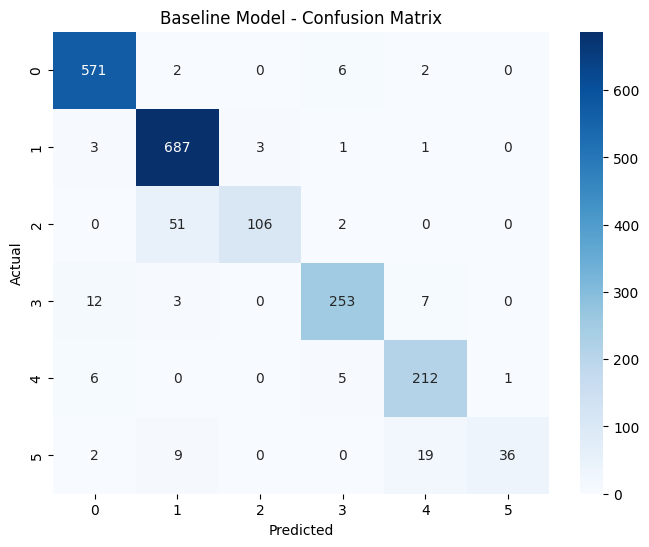

Baseline Model - Test Accuracy: 0.9325
Total Inference Time: 761.94 seconds
Average Time per Sample: 0.3810 seconds
Macro F1 Score: 0.8762


In [19]:
from sklearn.metrics import f1_score
from time import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Load the saved baseline model
model_baseline_loaded = AutoModelForSequenceClassification.from_pretrained("saved/baseline-model")
model_baseline_loaded.to(device)
model_baseline_loaded.eval()

# Perform inference and measure time
start_time = time()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running baseline inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model_baseline_loaded(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time()
inference_time = end_time - start_time

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Model - Confusion Matrix')
plt.show()


accuracy = correct / total
macro_f1 = f1_score(all_labels, all_predictions, average='macro')

print(f"Baseline Model - Test Accuracy: {accuracy:.4f}")
print(f"Total Inference Time: {inference_time:.2f} seconds")
print(f"Average Time per Sample: {inference_time/total:.4f} seconds")
print(f"Macro F1 Score: {macro_f1:.4f}")

### Code to run inference, calculate metrics (Accuracy, F1), and plot a Confusion Matrix for the Baseline Model

Running PTQ inference: 100%|██████████| 250/250 [12:06<00:00,  2.91s/it]


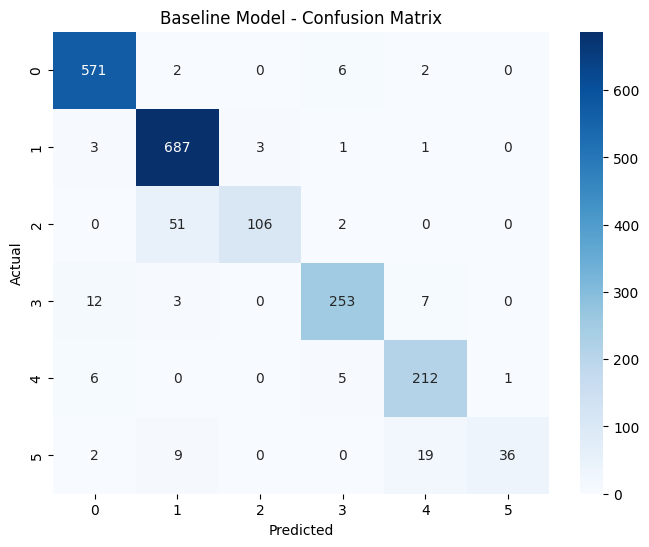

PTQ Model - Test Accuracy: 0.9325
Total Inference Time: 726.93 seconds
Average Time per Sample: 0.3635 seconds
Macro F1 Score: 0.8762


In [20]:
from peft import PeftModel

# Baseline model for quantization
model_baseline_cpu = AutoModelForSequenceClassification.from_pretrained("saved/baseline-model")
model_baseline_cpu.to("cpu")

model_baseline_cpu.eval()

start_time = time()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running PTQ inference"):
        input_ids = batch["input_ids"].cpu()
        attention_mask = batch["attention_mask"].cpu()
        labels = batch["labels"].cpu()
        
        outputs = model_baseline_cpu(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time()
inference_time = end_time - start_time

accuracy = correct / total
macro_f1 = f1_score(all_labels, all_predictions, average='macro')

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Model - Confusion Matrix')
plt.show()


print(f"PTQ Model - Test Accuracy: {accuracy:.4f}")
print(f"Total Inference Time: {inference_time:.2f} seconds")
print(f"Average Time per Sample: {inference_time/total:.4f} seconds")
print(f"Macro F1 Score: {macro_f1:.4f}")


### Code to run inference, calculate metrics (Accuracy, F1), and plot a Confusion Matrix for the QAT Model

Running QAT inference: 100%|██████████| 250/250 [12:00<00:00,  2.88s/it]


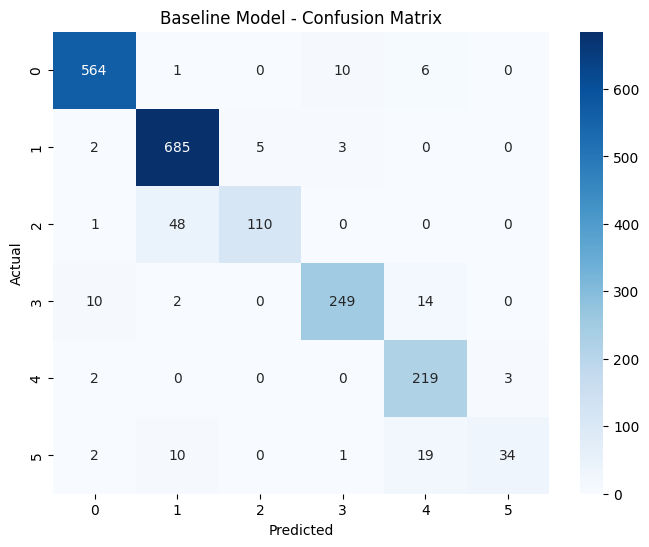

QAT Model - Test Accuracy: 0.9305
Total Inference Time: 720.55 seconds
Average Time per Sample: 0.3603 seconds
Macro F1 Score: 0.8698


In [21]:
model_qat_loaded = AutoModelForSequenceClassification.from_pretrained("saved/qat_bert_int8")
model_qat_loaded.to(device)
model_qat_loaded.eval()

start_time = time()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running QAT inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model_qat_loaded(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time()
inference_time = end_time - start_time

accuracy = correct / total
macro_f1 = f1_score(all_labels, all_predictions, average='macro')

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Model - Confusion Matrix')
plt.show()


print(f"QAT Model - Test Accuracy: {accuracy:.4f}")
print(f"Total Inference Time: {inference_time:.2f} seconds")
print(f"Average Time per Sample: {inference_time/total:.4f} seconds")
print(f"Macro F1 Score: {macro_f1:.4f}")



### Code to run inference, calculate metrics (Accuracy, F1), and plot a Confusion Matrix for the Q-LoRA Adapter Model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Running Q-LoRA inference: 100%|██████████| 250/250 [13:31<00:00,  3.25s/it]


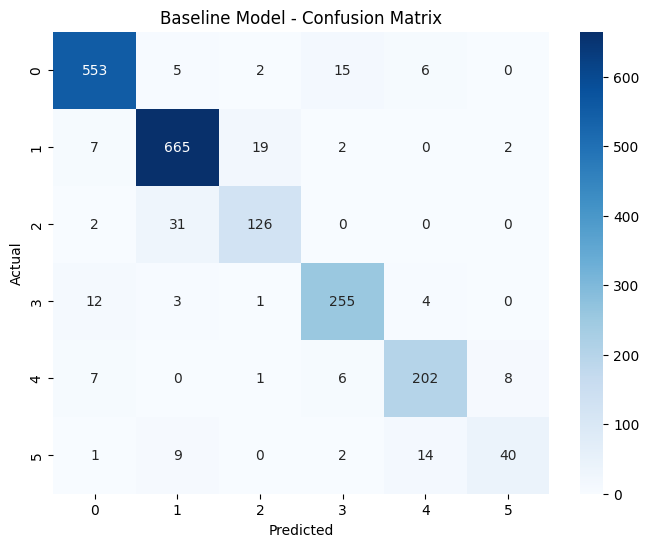

Q-LoRA Model - Test Accuracy: 0.9205
Total Inference Time: 811.63 seconds
Average Time per Sample: 0.4058 seconds
Macro F1 Score: 0.8700


In [22]:
model_qlora_loaded = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=6)
model_qlora_loaded = PeftModel.from_pretrained(model_qlora_loaded, "saved/qlora-bert-adapter")
model_qlora_loaded.to(device)
model_qlora_loaded.eval()

start_time = time()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running Q-LoRA inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model_qlora_loaded(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time()
inference_time = end_time - start_time

accuracy = correct / total
macro_f1 = f1_score(all_labels, all_predictions, average='macro')

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Model - Confusion Matrix')
plt.show()


print(f"Q-LoRA Model - Test Accuracy: {accuracy:.4f}")
print(f"Total Inference Time: {inference_time:.2f} seconds")
print(f"Average Time per Sample: {inference_time/total:.4f} seconds")
print(f"Macro F1 Score: {macro_f1:.4f}")